<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
# загрузим наш датасет, индексами сделаем первую колонку в которой находятся даты
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# проверим на пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [4]:
# изучим размер датасета
df.shape

(26496, 1)

In [5]:
# посмотрим первые 5 строк датасета
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# проверим что все даты идут по порядку
df.index.is_monotonic

True

In [7]:
# ресемплируем с 10минутных интервалов на часовые и проверим изменения
df = df.resample('1H').sum()

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
# посмотрим минимальное и максимальное количество заказов за час
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [9]:
# посмотрим сколько наблюдений получилось после ресемплирования
df.shape

(4416, 1)

Данные в порядке и представлены как количество заказов каждые 10 минут с 1 марта 2018г по 31 августа того же года. Индексы идут по порядку. Данные были ресемплированы с 10 минутного интервал в часовой с суммированием заказов. Минимальное количество заказов в час - 0, максимальное - 462. Данные последовательны и в них отсутствуют пропуски.

## Анализ

In [10]:
# декомпозируем данные:
decomposed = seasonal_decompose(df)
decomposed_last_month = seasonal_decompose(df['2018-08-01':])
decomposed_last_week = seasonal_decompose(df['2018-08-25':])

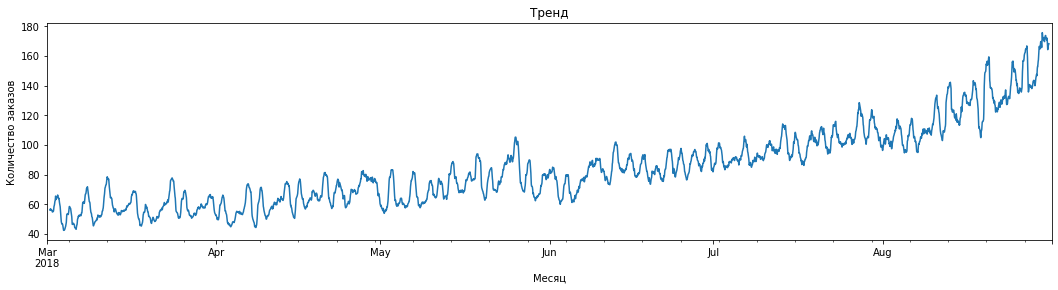

In [11]:
# отрисуем график тренда за весь изучаемый период
decomposed.trend.plot(figsize=(18, 4))
plt.title('Тренд')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

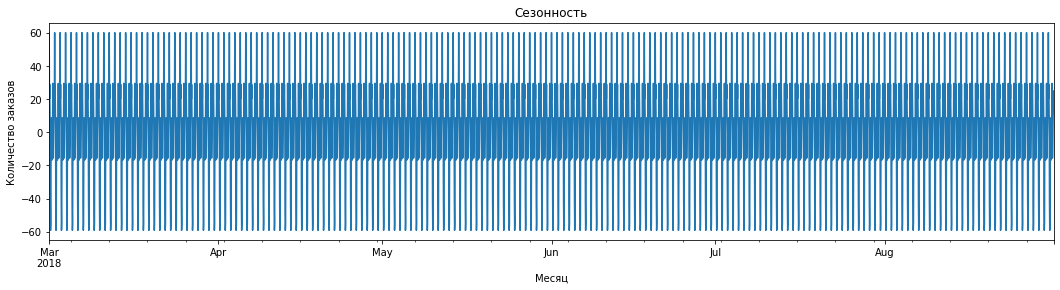

In [12]:
# отрисуем график сезонности за весь изучаемый период
decomposed.seasonal.plot(figsize=(18, 4))
plt.title('Сезонность')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

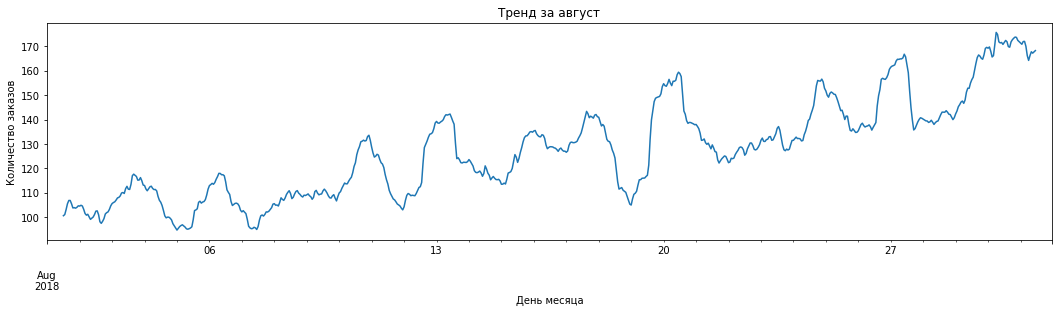

In [13]:
# отрисуем график тренда за август
decomposed_last_month.trend.plot(figsize=(18, 4))
plt.title('Тренд за август')
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.show()

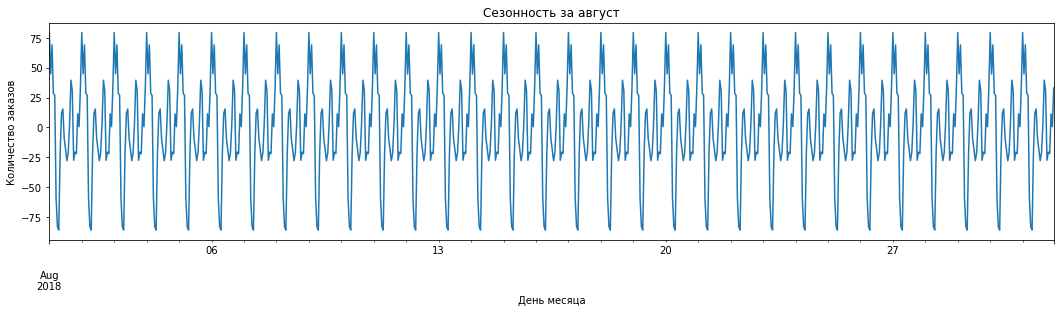

In [14]:
# отрисуем график сезонности за август
decomposed_last_month.seasonal.plot(figsize=(18, 4))
plt.title('Сезонность за август')
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.show()

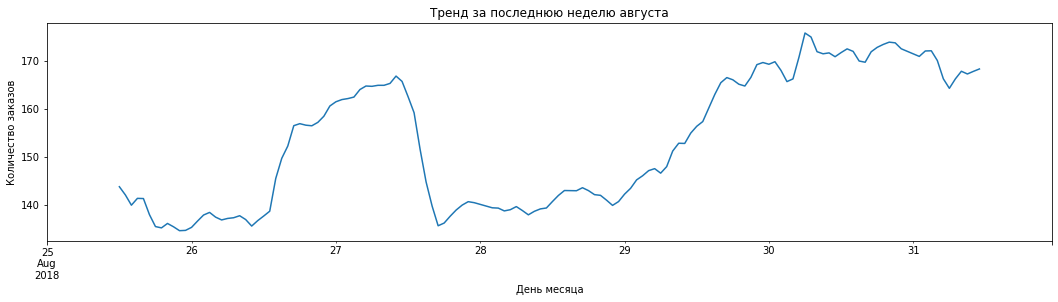

In [15]:
# отрисуем график тренда за последнии 7 дней августа
decomposed_last_week.trend.plot(figsize=(18, 4))
plt.title('Тренд за последнюю неделю августа')
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.show()

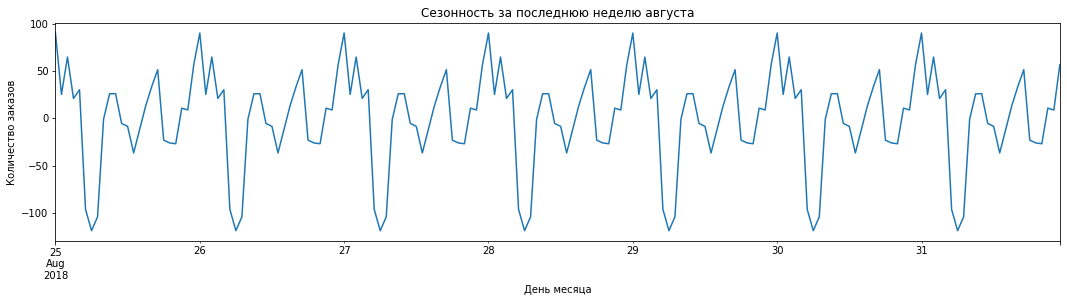

In [16]:
# отрисуем график сезонности за последнии 7 дней августа
decomposed_last_week.seasonal.plot(figsize=(18, 4))
plt.title('Сезонность за последнюю неделю августа')
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.show()

По графикам тренда виден постоянный рост, количество заказов с марта по сентябрь постоянно растет. Так же отчетливо видна дневная сезонность, максимальная просадка заказов в районе 5 утра а максимальный пик в 12 часов ночи. По дням недели наблюдается повышенный спрос в пн, чт и пт. Так как данных у нас всего за несколько месяцев с марта по август включительно мы не можем точно сказать что у нас постоянный растущий тренд, это может быть подъем к сезону отпусков например.

## Обучение

In [17]:
# напишем функцию для генерации новых признаков (день недели, час, смещение и скользящее среднее)
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
# добавим новые признаки, возьмем смещение 2 и скользящее среднее за сутки, проверим изменения
make_features(df, 2, 24)

df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN


In [19]:
# разделим датасет на тестовую и обучающую выборки и разделим каждую на признаки и таргет
# из обучающей выборки удалим все пропуски
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [20]:
# определим переменную для random_state и TimeSeriesSplit
# n_splits=9 чтобы 10% выборки было тестовой при кросс валидации
tscv = TimeSeriesSplit(n_splits=9)
rs = 42

In [21]:
# Обучим модель LinearRegression и посчитаем RMSE на обучающей выборке

LR = LinearRegression()
      
rmse_LR = cross_val_score(LR,
                          X_train, 
                          y_train, 
                          cv=tscv, 
                          n_jobs=-1, 
                          scoring='neg_root_mean_squared_error').mean() * -1

print("RMSE LR на обучающей выборке:", rmse_LR)

RMSE LR на обучающей выборке: 31.279006039056842


In [22]:
%%time
# подберем лучшие параметры для модели RandomForestRegressor
# выведем на экран лучшие параметры и rmse

RFR = RandomForestRegressor(random_state=rs) 
params = {'max_depth': np.arange(2, 17, 2),
          'n_estimators': np.arange(40, 71, 10)}

grid = GridSearchCV(RFR, 
                    param_grid=params,
                    cv=tscv,
                    n_jobs=-1,
                    verbose=1,
                    scoring='neg_root_mean_squared_error')

grid.fit(X_train, y_train)

print(grid.best_params_)
    
rmse_RFR = (max(grid.cv_results_['mean_test_score']) * -1)
print("RMSE RFR на обучающей выборке:", rmse_RFR)

Fitting 9 folds for each of 32 candidates, totalling 288 fits
{'max_depth': 14, 'n_estimators': 60}
RMSE RFR на обучающей выборке: 24.554096139411122
CPU times: user 59.9 s, sys: 354 ms, total: 1min
Wall time: 1min


In [23]:
%%time
# подберем лучшие параметры для модели LGBMRegressor
# выведем на экран лучшие параметры и rmse

LGBMR = LGBMRegressor(random_state=rs) 
params = {'num_leaves': [75, 100, 150, 200], 
          'learning_rate': [.1, .2, .3]}

grid = GridSearchCV(LGBMR,
                    param_grid=params,
                    cv=tscv,
                    n_jobs=-1,
                    verbose=1,
                    scoring='neg_root_mean_squared_error')

grid.fit(X_train, y_train)

print(grid.best_params_)

rmse_LGBMR = (max(grid.cv_results_['mean_test_score']) * -1)
print("RMSE LGBMR на обучающей выборке:", rmse_LGBMR)

Fitting 9 folds for each of 12 candidates, totalling 108 fits
{'learning_rate': 0.1, 'num_leaves': 75}
RMSE LGBMR на обучающей выборке: 24.46360406775625
CPU times: user 3min 26s, sys: 1.93 s, total: 3min 27s
Wall time: 3min 30s


In [24]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
# выведем на экран лучшие параметры и rmse

CBR = CatBoostRegressor(loss_function='RMSE', random_state=rs, verbose=False) 
params = {'depth': [8, 10],
          'learning_rate': np.arange(0.1, 0.4, 0.1)}

grid = GridSearchCV(CBR,
                    param_grid=params,
                    cv=tscv,
                    n_jobs=-1,
                    verbose=1,
                    scoring='neg_root_mean_squared_error')

grid.fit(X_train, y_train)

print(grid.best_params_)
    
rmse_CBR = (max(grid.cv_results_['mean_test_score']) * -1)
print("RMSE CBR на обучающей выборке:", rmse_CBR)

Fitting 9 folds for each of 8 candidates, totalling 72 fits
{'depth': 10, 'learning_rate': 0.1}
RMSE CBR на обучающей выборке: 25.008913846013883
CPU times: user 5min 27s, sys: 8.97 s, total: 5min 36s
Wall time: 6min 35s


In [25]:
# выведем на экран таблицу с итогами исследования
models = ['LinearRegression', 'RandomForestRegressor', 'LGBMRegressor', 'CatBoostRegressor']
table = pd.DataFrame(np.array([rmse_LR, rmse_RFR, rmse_LGBMR, rmse_CBR]), index=models)
table.set_axis(['rmse'], axis=1, inplace=True)

table

,rmse
LinearRegression,31.279006
RandomForestRegressor,24.554096
LGBMRegressor,24.463604
CatBoostRegressor,25.008914


Было обучено 4 модели, подобраны лучшие гиперпараметры. Модель LGBMRegressor показала лучшие результаты по метрике RMSE. Проверим ее на тестовой выборке.

## Тестирование

In [26]:
# обучим модель CBR с подобранными гиперпараметрами
LGBMR = LGBMRegressor(random_state=rs,
                      num_leaves=75,
                      learning_rate=0.1)

LGBMR.fit(X_train, y_train)

# создадим предикт по тестовой выборке
LGBMR_predict = LGBMR.predict(X_test)

# посчитаем и выведем rmse для CatBoostRegressor
LGBMR_rmse = mean_squared_error(y_test, LGBMR_predict, squared=False)
LGBMR_rmse

45.38873242414259

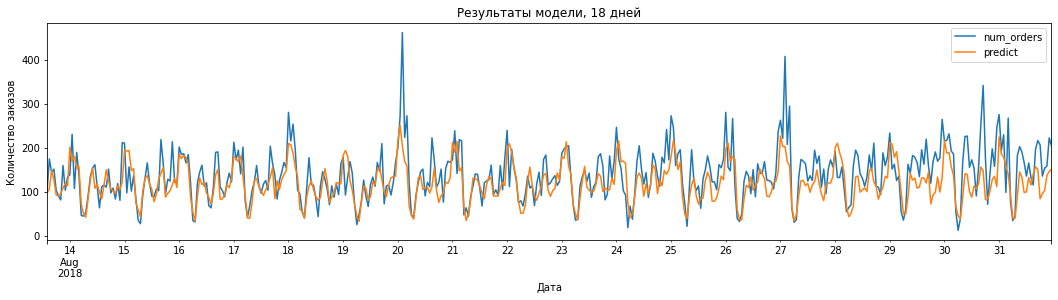

In [27]:
# построим график предсказаний и таргета для сравнения по всей тестовой выборке
pl = pd.DataFrame(y_test.copy())
pl['predict'] = LGBMR_predict
pl.plot(figsize=(18, 4))
plt.title('Результаты модели, 18 дней')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

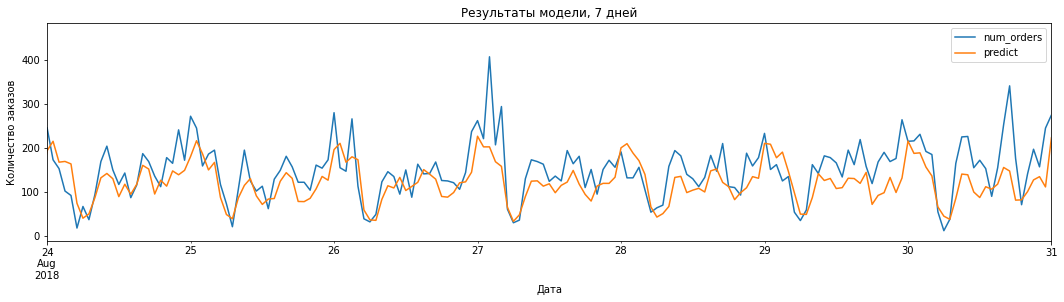

In [28]:
# построим график за неделю
pl.plot(figsize=(18, 4), xlim=('2018-08-24', '2018-08-31'))
plt.title('Результаты модели, 7 дней')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

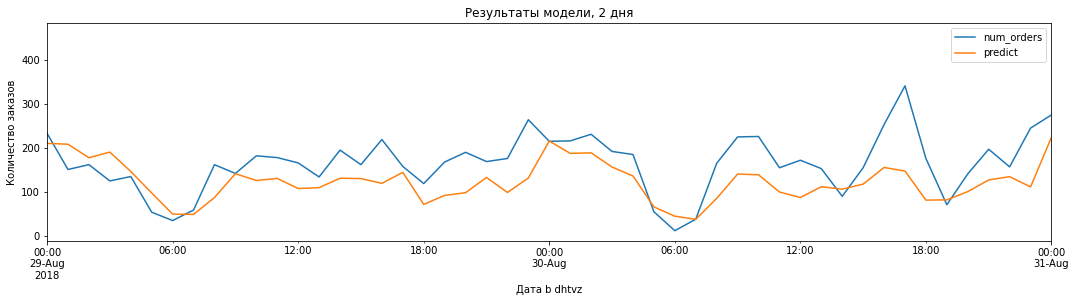

In [29]:
# построим график за 2 lyz
pl.plot(figsize=(18, 4), xlim=('2018-08-29', '2018-08-31'))
plt.title('Результаты модели, 2 дня')
plt.xlabel('Дата b dhtvz')
plt.ylabel('Количество заказов')
plt.show()

Модель LGBMRegressor на тестовой выборке показала RMSE 45.39, поставленная цель (добиться RMSE ниже 48) можно считать выполненой. По графикам соотножения предсказания и реальных данных можно заметить что модель очень точно предсказывает снижение заказов но чаще ошибается в предсказаниях пиковой загруженности